Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0092 - val_loss: 7.3003e-05
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0018 - val_loss: 7.1720e-05
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0017 - val_loss: 5.8686e-05
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0016 - val_loss: 6.7996e-05
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0010 - val_loss: 8.5440e-05
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0017 - val_loss: 1.2153e-04
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.0578e-04 - val_loss: 5.3064e-04
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011 - val_loss: 2.9554e-04
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 9.8037e-04 - val_loss: 9.1660e-05
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0012 - val_loss: 7.0603e-05
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0010 - val_loss: 7

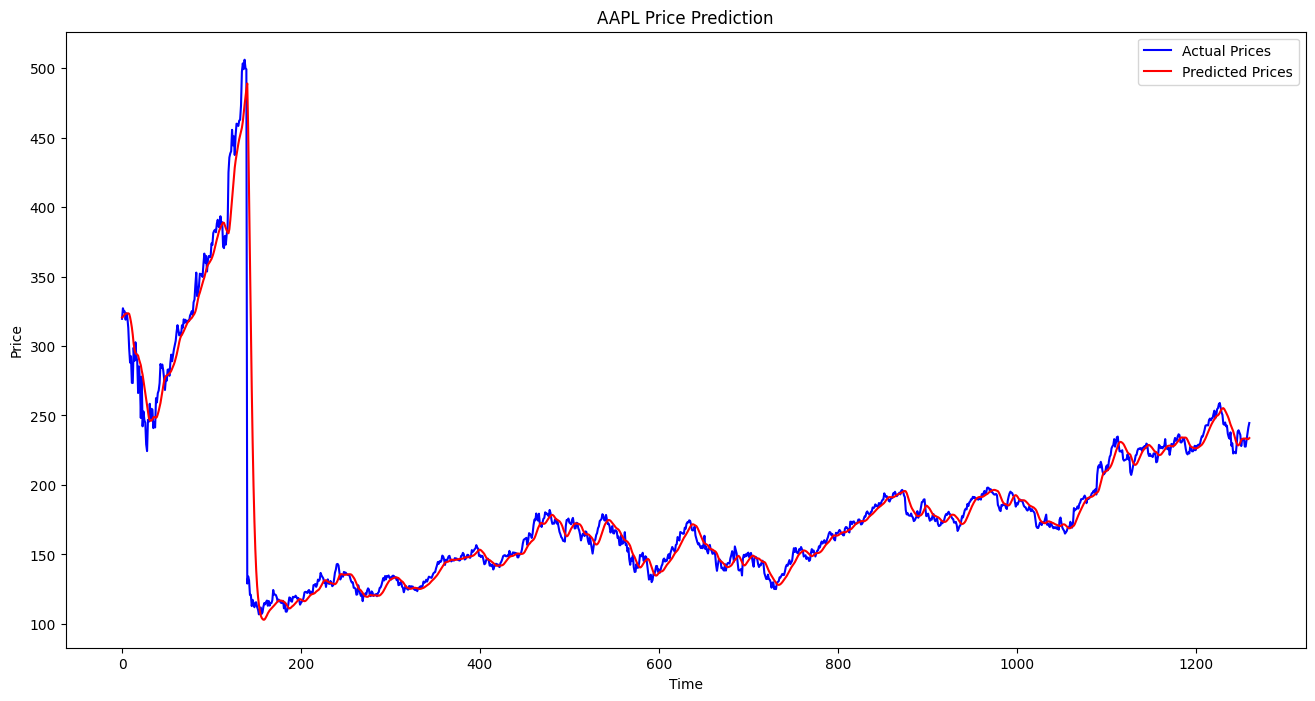

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Current price: $244.60
Predicted next price: $235.14
Trading decision: SELL
Model saved as AAPL_lstm_model.h5


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def prepare_data(df, target_symbol, sequence_length=60):
    """
    Prepare data for LSTM model
    
    Parameters:
    df (pandas.DataFrame): Dataframe containing stock data
    target_symbol (str): Symbol to predict
    sequence_length (int): Number of previous days to use for prediction
    
    Returns:
    tuple: (X_train, X_test, y_train, y_test, scaler)
    """

    target_df = df[df['symbol'] == target_symbol].sort_values('date')
    

    features = ['open', 'high', 'low', 'close', 'volume']
    data = target_df[features].values
    

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # Prepare sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i+sequence_length])

        y.append(scaled_data[i+sequence_length, 3])  # 3 is the index for 'close'
    
    X, y = np.array(X), np.array(y)
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    return X_train, X_test, y_train, y_test, scaler


def create_lstm_model(input_shape):
    """
    Create an LSTM model for stock price prediction
    
    Parameters:
    input_shape (tuple): Shape of input data
    
    Returns:
    tensorflow.keras.models.Sequential: LSTM model
    """
    model = Sequential()
    

    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    

    model.add(Dense(units=25))
    model.add(Dense(units=1))  # Output layer
    

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

def train_model(X_train, y_train, epochs=50, batch_size=32):
    """
    Train the LSTM model
    
    Parameters:
    X_train (numpy.array): Training features
    y_train (numpy.array): Training target
    epochs (int): Number of training epochs
    batch_size (int): Batch size for training
    
    Returns:
    tuple: (model, history)
    """
    model = create_lstm_model(X_train.shape[1:])
    

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, X_test, y_test, scaler, features_shape):
    """
    Evaluate the model on test data
    
    Parameters:
    model (tensorflow.keras.models.Sequential): Trained model
    X_test (numpy.array): Test features
    y_test (numpy.array): Test target
    scaler (MinMaxScaler): Scaler used for normalization
    features_shape (int): Number of features
    
    Returns:
    tuple: (predictions, actual)
    """

    predictions = model.predict(X_test)
    

    dummy = np.zeros((len(predictions), features_shape))
    dummy[:, 3] = predictions.flatten()  # 3 is the index for 'close'
    predictions_transformed = scaler.inverse_transform(dummy)[:, 3]

    dummy = np.zeros((len(y_test), features_shape))
    dummy[:, 3] = y_test
    actual_transformed = scaler.inverse_transform(dummy)[:, 3]

    mse = np.mean((predictions_transformed - actual_transformed) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_transformed - actual_transformed))
    
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    

    actual_direction = np.diff(actual_transformed, prepend=actual_transformed[0])
    predicted_direction = np.diff(predictions_transformed, prepend=predictions_transformed[0])
    

    actual_direction = actual_direction[1:]
    predicted_direction = predicted_direction[1:]
    

    correct_direction = (np.sign(actual_direction) == np.sign(predicted_direction)).sum()
    directional_accuracy = correct_direction / len(actual_direction) * 100
    
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    threshold = 0.01  # 1% change
    

    actual_returns = actual_direction / actual_transformed[:-1]
    predicted_returns = predicted_direction / predictions_transformed[:-1]
    

    buy_signals = predicted_returns > threshold
    if buy_signals.sum() > 0:
        correct_buys = (actual_returns[buy_signals] > 0).sum()
        buy_accuracy = correct_buys / buy_signals.sum() * 100
        print(f"Buy Signal Accuracy: {buy_accuracy:.2f}% ({correct_buys}/{buy_signals.sum()})")
    else:
        print("No buy signals generated")
    

    sell_signals = predicted_returns < -threshold
    if sell_signals.sum() > 0:
        correct_sells = (actual_returns[sell_signals] < 0).sum()
        sell_accuracy = correct_sells / sell_signals.sum() * 100
        print(f"Sell Signal Accuracy: {sell_accuracy:.2f}% ({correct_sells}/{sell_signals.sum()})")
    else:
        print("No sell signals generated")
    

    trading_signals = np.logical_or(buy_signals, sell_signals)
    if trading_signals.sum() > 0:
        correct_trades = (actual_returns[buy_signals] > 0).sum() + (actual_returns[sell_signals] < 0).sum()
        trading_accuracy = correct_trades / trading_signals.sum() * 100
        print(f"Overall Trading Accuracy: {trading_accuracy:.2f}% ({correct_trades}/{trading_signals.sum()})")
    else:
        print("No trading signals generated")
    
    return predictions_transformed, actual_transformed

def plot_results(actual, predictions, target_symbol):
    """
    Plot actual vs predicted prices
    
    Parameters:
    actual (numpy.array): Actual prices
    predictions (numpy.array): Predicted prices
    target_symbol (str): Stock symbol
    """
    plt.figure(figsize=(16, 8))
    plt.plot(actual, color='blue', label='Actual Prices')
    plt.plot(predictions, color='red', label='Predicted Prices')
    plt.title(f'{target_symbol} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def make_trading_decision(model, latest_data, scaler, threshold=0.01):
    """
    Make a trading decision based on the model's prediction
    
    Parameters:
    model (tensorflow.keras.models.Sequential): Trained model
    latest_data (numpy.array): Latest sequence of data
    scaler (MinMaxScaler): Scaler used for normalization
    threshold (float): Threshold for deciding to buy/sell
    
    Returns:
    str: Trading decision ('buy', 'sell', or 'hold')
    float: Predicted next price
    float: Current price
    """

    latest_sequence = latest_data[-1:].reshape(1, latest_data.shape[1], latest_data.shape[2])
    

    next_price_scaled = model.predict(latest_sequence)[0, 0]
    

    current_price_scaled = latest_sequence[0, -1, 3]  # 3 is the index for 'close'
    

    dummy = np.zeros((1, latest_data.shape[2]))
    
    dummy[0, 3] = next_price_scaled
    next_price = scaler.inverse_transform(dummy)[0, 3]
    
    dummy[0, 3] = current_price_scaled
    current_price = scaler.inverse_transform(dummy)[0, 3]
    

    expected_return = (next_price - current_price) / current_price
    

    if expected_return > threshold:
        decision = 'buy'
    elif expected_return < -threshold:
        decision = 'sell'
    else:
        decision = 'hold'
    
    return decision, next_price, current_price

def main():

    df = pd.read_csv('/Users/devshah/Documents/WorkSpace/University/year 3/CSC392/Trading_Simulator/data/stock_data.csv', index_col=0)
    df['date'] = pd.to_datetime(df['date'])
    

    target_symbol = 'AAPL'  # Change to your desired stock
    

    X_train, X_test, y_train, y_test, scaler = prepare_data(df, target_symbol)
    

    model, history = train_model(X_train, y_train, epochs=100)
    

    predictions, actual = evaluate_model(model, X_test, y_test, scaler, X_train.shape[2])
    

    plot_results(actual, predictions, target_symbol)
    

    target_df = df[df['symbol'] == target_symbol].sort_values('date')
    features = ['open', 'high', 'low', 'close', 'volume']
    latest_data = target_df[features].values[-60:] 
    latest_data = scaler.transform(latest_data).reshape(1, 60, 5)
    

    decision, next_price, current_price = make_trading_decision(model, latest_data, scaler)
    
    print(f"Current price: ${current_price:.2f}")
    print(f"Predicted next price: ${next_price:.2f}")
    print(f"Trading decision: {decision.upper()}")
    

    model.save(f'{target_symbol}_lstm_model.h5')
    print(f"Model saved as {target_symbol}_lstm_model.h5")

if __name__ == "__main__":
    main()